In [1]:
import numpy as np
from scipy.io import loadmat
from localizer import Localizer
import psi4
from iodata import load_one, dump_one
import electrostatics as esp

#https://github.com/molmod/molmod
from molmod.units import angstrom, debye

import matplotlib.pyplot as plt

#importing the QM7 database
# data = dict(loadmat('../molecule_geometries/qm7.mat'))
# Z = data['Z'] # numbers
# R = data['R']/angstrom # positions in angstrom

#importing the centered QM7 database
Z = np.load('../data/molecule_geometries/qm7_Z.npy')
R = np.load('../data/molecule_geometries/qm7_R_centered.npy')

# Molecule order: H2O,CO2,HCN,Acetonitrile,H2SO4,Benzene,Diborane
numbers = np.load('../data/molecule_geometries/nuclei_numbers.npy')
positions = np.load('../data/molecule_geometries/positions.npy')

In [24]:
idx = 31
loc = Localizer(Z[idx], R[idx], index=idx, check_import=False, cores=4, memory=6e+09)

generating data for: 0031_NC3H7
Psi4 Model initiated with method scf and basis set 6-311ppg_d_p_
writing out psi4 data for molecule: 0031_NC3H7


In [27]:
loc.set_scheme('V5',p=5.)

In [28]:
loc.optimize_line_search()

Optimizing cost function: V5
root out of range
reset at iteration:56
reset at iteration:57
reset at iteration:58
reset at iteration:59
reset at iteration:60
Conjugate gradient resetted 5 consecutive times: REINITIALIZING
Optimizing cost function: V5
reset at iteration:33
reset at iteration:34
reset at iteration:35
reset at iteration:36
reset at iteration:37
Conjugate gradient resetted 5 consecutive times: REINITIALIZING
Optimizing cost function: V5
reset at iteration:30
reset at iteration:31
reset at iteration:32
reset at iteration:33
reset at iteration:34
Conjugate gradient resetted 5 consecutive times: REINITIALIZING
Optimizing cost function: V5
reset at iteration:20
reset at iteration:21
reset at iteration:22
reset at iteration:23
reset at iteration:24
Conjugate gradient resetted 5 consecutive times: REINITIALIZING
Optimizing cost function: V5
reset at iteration:47
reset at iteration:48
reset at iteration:49
reset at iteration:50
reset at iteration:51
Conjugate gradient resetted 5 c

True

## Checking E_rmsd hyper parameters

In [26]:
loc.compute_esp_rmsd(r_max=10.0,min_points=50000)

generating grid
Calculating QM ESP at the gridpoints
Saving QM ESP
Computing classical ESP
Valid points: 18047


0.027068002568006604

In [29]:
loc.compute_esp_rmsd(r_max=10.0,min_points=50000)

generating grid
Potential data loaded
Computing classical ESP
Valid points: 18047


0.02181946715435861

In [23]:
npoints1 = [1000,2000,5000,10000,20000,50000,100000,200000,500000]
Ermsd1 = []
valid_points = []
for p in npoints:
    loc.compute_esp_rmsd(min_points=p)
    Ermsd1.append(loc.Ermsd)
    valid_points.append(loc.esp_points)

generating grid
Potential data loaded
Computing classical ESP
Valid points: 202
generating grid
Potential data loaded
Computing classical ESP
Valid points: 490
generating grid
Potential data loaded
Computing classical ESP
Valid points: 1428
generating grid
Potential data loaded
Computing classical ESP
Valid points: 2661
generating grid
Potential data loaded
Computing classical ESP
Valid points: 5679
generating grid
Potential data loaded
Computing classical ESP
Valid points: 13490
generating grid
Potential data loaded
Computing classical ESP
Valid points: 28116
generating grid
Potential data loaded
Computing classical ESP
Valid points: 56246
generating grid
Potential data loaded
Computing classical ESP
Valid points: 142252


Text(0.5, 0, 'number of included points')

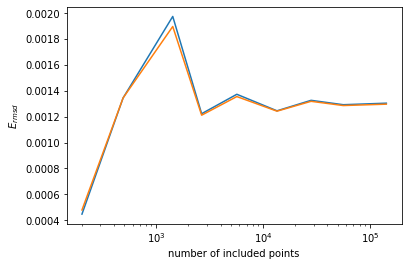

In [25]:
plt.plot(valid_points, Ermsd1)
plt.plot(valid_points, Ermsd2)
plt.xscale('log')
plt.ylabel('$E_{rmsd}$')
plt.xlabel('number of included points')

In [4]:
rmax = [6.,6.5,7.,7.5,8.,8.5,9.,9.5,10.]
Ersd = []
valid_points = []
for r in rmax:
    loc.compute_esp_rrmsd(r_max=r,min_points=50000)
    Ersd.append(loc.Ersd)
    valid_points.append(loc.esp_points)

generating grid
Potential data loaded
Computing classical ESP
Valid points: 12283
generating grid
Potential data loaded
Computing classical ESP
Valid points: 12935
generating grid
Potential data loaded
Computing classical ESP
Valid points: 13490
generating grid
Potential data loaded
Computing classical ESP
Valid points: 13934
generating grid
Potential data loaded
Computing classical ESP
Valid points: 14374
generating grid
Potential data loaded
Computing classical ESP
Valid points: 14796
generating grid
Potential data loaded
Computing classical ESP
Valid points: 15162
generating grid
Potential data loaded
Computing classical ESP
Valid points: 15491
generating grid
Potential data loaded
Computing classical ESP
Valid points: 15848


Text(0.5, 0, '$r_{max}$')

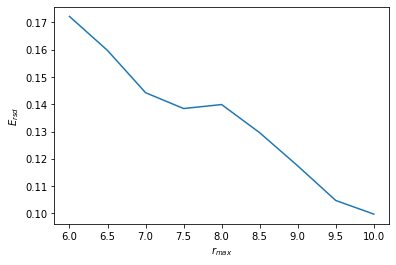

In [6]:
plt.plot(rmax, Ersd)
# plt.xscale('log')
plt.ylabel('$E_{rsd}$')
plt.xlabel('$r_{max}$')

## Centering the molecule positions

In [2]:
data = dict(loadmat('../molecule_geometries/qm7.mat'))
Z = data['Z'] # numbers
R = data['R']/angstrom # positions in angstrom

centered_R = np.zeros(np.shape(R))
for i, pos in enumerate(R):
    idxs = np.where(Z[i] != 0)
    r = pos[idxs].transpose()
    r[0] -= np.mean(r[0])
    r[1] -= np.mean(r[1])
    r[2] -= np.mean(r[2])
    centered_R[i,idxs] = r.transpose()

np.save('../molecule_geometries/qm7_R_centered', centered_R)
np.save('../molecule_geometries/qm7_Z', Z)

## Check if the grid and potential are okay

In [5]:
idx = 6
# loc = Localizer(Z[idx], r.transpose()[:5], index=idx, check_import=True)
loc = Localizer(Z[idx], R[idx], index=idx, check_import=True)

grid = esp.generate_grid(loc.R,r_max=10, min_points=10000)
mask = esp.generate_mask(grid, loc.R, loc.Z)

# Put grid in a format so that psi4 can read it in.
grid = np.moveaxis(grid,0,-1)

# Psi4 will look for a grid.dat file when calculating
# the ESP using the density.
int_grid = np.moveaxis(grid[np.where(mask == -1)], 0, 1)
on_grid = np.moveaxis(grid[np.where(mask == 1)], 0, 1)
ext_grid = np.moveaxis(grid[np.where(mask == 0)], 0, 1)

%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(int_grid[0],int_grid[1],int_grid[2], marker='.', c='r', alpha=0.3)
ax.scatter(on_grid[0],on_grid[1],on_grid[2], marker='.', c='b', alpha=0.3)
# ax.scatter(ext_grid[0],ext_grid[1],ext_grid[2], marker='.', c='y', alpha=0.2)
_R = loc.R.transpose()
ax.scatter(_R[0], _R[1], _R[2], marker='o', c='k', alpha=0.9)

plt.show()

Imported data for: 0006_OC2H6


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …